<a href="https://colab.research.google.com/github/james-nightingale-1/Customer_Churn/blob/main/Churn_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1- Intro: Customer Churn Project

In this project, I built a Random Forest Classifier to predict customer churn. The model can be used both to **identify at-risk customers for retention campaigns** and to **understand the key features driving churn**, helping companies target promotions more effectively.  

The project is structured as follows:
* **Section 2**: Data cleaning, encoding categorical variables, and removing unnecessary columns.  
* **Section 3**: Train/test split, model training with Random Forest, and hyperparameter tuning with a focus on predictive accuracy and reducing false negatives.  
* **Section 4**: Visualisation of feature importance and model performance metrics.  
* **Section 5**: Key business insights and conclusions.

# 2- Data Preprocessing and Import Statements

In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import shap

from matplotlib.colors import LinearSegmentedColormap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

In [ ]:
data = pd.read_csv("churn.csv")

In [ ]:
data.duplicated().sum()

np.int64(0)

In [ ]:
data.isna().any().sum()

np.int64(0)

In [ ]:
binary_cols = ["Partner", "Dependents", "PhoneService",
               "MultipleLines", "OnlineSecurity", "OnlineBackup",
               "DeviceProtection", "TechSupport", "StreamingTV",
               "StreamingMovies", "PaperlessBilling", "Churn"]
data[binary_cols] = data[binary_cols].applymap(lambda x: 1 if x == "Yes" else 0)
data["gender"] = data["gender"].apply(lambda x: 1 if x == "Male" else 0)
data = pd.get_dummies(data, columns=["InternetService", "PaymentMethod"])
contract_map = {
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2
}
data["Contract"] = data["Contract"].map(contract_map)
data = data.drop(columns=["customerID"])
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
data["TotalCharges"] = data["TotalCharges"].fillna(0)
data = data.astype(float)

/tmp/ipython-input-272708419.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[binary_cols] = data[binary_cols].applymap(lambda x: 1 if x == "Yes" else 0)


In [ ]:
data['Churn'].value_counts(normalize=True)

,proportion
Churn,
0.0,0.73463
1.0,0.26537


# 3- Random Forest Model

## Split into test and training data

In [ ]:
y = data["Churn"]
X = data.drop(["Churn"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

## Baseline model

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    random_state=12,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Confusion Matrix:
[[948  95]
 [178 188]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1043
         1.0       0.66      0.51      0.58       366

    accuracy                           0.81      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409


ROC-AUC: 0.8368108493259775


## Weighted Sampling

We have weighted the churn class three times higher than the non-churn class to reflect the greater business cost of missing a churner (false negative) compared to incorrectly predicting churn (false positive). In a real-world setting, these weights can be directly calibrated based on the ratio of the financial loss incurred from losing a customer versus the cost of retention or marketing interventions. This ensures that the model’s predictions align with business priorities and economic impact.

$$
TC = \text{FN count} \cdot C_{fn} + \text{FP count} \cdot C_{fp}
$$

In [ ]:
weights = {0: 1, 1:3}
rf = RandomForestClassifier(
    class_weight=weights,
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    random_state=12,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Confusion Matrix:
[[801 242]
 [ 90 276]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.77      0.83      1043
         1.0       0.53      0.75      0.62       366

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.78      1409


ROC-AUC: 0.8371094834677189


Thus, we get a much higher (75% vs 51%) recall for churn. This is very important as we don't want to lose false positives.

## Tuning for ROC-AUC

Here, we search for the parameters that optimise area under the ROC curve for our random forest model. We recommend not running this section if you are scrolling through due to long processing times.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight={0:1, 1:3}, random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)

{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 200} 0.8476885646625503


In [ ]:
param_grid_refined = {
    'max_depth': [13, 15, 17],
    'min_samples_leaf': [8, 10, 12],
    'max_features': ['sqrt'],
    'n_estimators': [150, 200, 250]
}

grid_refined = GridSearchCV(
    RandomForestClassifier(class_weight={0:1, 1:3}, random_state=42),
    param_grid_refined,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_refined.fit(X_train, y_train)
print(grid_refined.best_params_, grid_refined.best_score_)

{'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'n_estimators': 150} 0.8483848999129444


In [ ]:
param_grid_refined = {
    'max_depth': [12, 13, 14],
    'min_samples_leaf': [11, 12, 13],
    'max_features': ['sqrt'],
    'n_estimators': [140, 150, 160]
}

grid_refined = GridSearchCV(
    RandomForestClassifier(class_weight={0:1, 1:3}, random_state=42),
    param_grid_refined,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid_refined.fit(X_train, y_train)
print(grid_refined.best_params_, grid_refined.best_score_)

{'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'n_estimators': 150} 0.8483848999129444


## Final Model

In [ ]:
weights = {0: 1, 1:3}
rf = RandomForestClassifier(
    class_weight=weights,
    n_estimators=150,
    max_depth=13,
    min_samples_leaf=12,
    random_state=12,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

Confusion Matrix:
[[777 266]
 [ 77 289]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82      1043
         1.0       0.52      0.79      0.63       366

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.76      0.77      1409


ROC-AUC: 0.8374605095641513


### Insights

* The model is both highly **accurate**, capturing around 84% of customer churn behaviour, and **prioritises reducing false negatives**, meaning it is more likely to correctly identify customers who will churn.

* It can be used to **predict which customers are at risk of leaving**, enabling targeted retention campaigns and interventions.

* Using customer indices, we can retrieve demographic and account information to **tailor promotions and offers** to those most likely to churn (e.g., age, location, contract type).

## Evaluating Thresholds

Referring back to our equation, we again assume that the cost of a false negative is 3x higher than a false positive, so that $C_{fn}$ is three times larger than $C_{fp}$. We then find the threshold that minimises this latter equation.

$$
TC = \text{FN count} \cdot C_{fn} + \text{FP count} \cdot C_{fp}
$$

Therefore,

$$
TC = 3 \cdot \text{FN count} + \text{FP count}
$$

In [ ]:
y_proba = rf.predict_proba(X_test)[:,1]
for t in np.arange(0.3, 0.75, 0.05):
  y_pred = (y_proba >= t).astype(int)
  fp_count = confusion_matrix(y_test, y_pred)[0, 1]
  fn_count = confusion_matrix(y_test, y_pred)[1, 0]
  print(f"Threshold: {round(t, 2)}\n Cost: {(3 * fn_count) + fp_count}")

Threshold: 0.3
 Cost: 566
Threshold: 0.35
 Cost: 557
Threshold: 0.4
 Cost: 539
Threshold: 0.45
 Cost: 517
Threshold: 0.5
 Cost: 497
Threshold: 0.55
 Cost: 532
Threshold: 0.6
 Cost: 544
Threshold: 0.65
 Cost: 582
Threshold: 0.7
 Cost: 615


This shows that the default threshold of 0.5 is the best for our model. No adjustments are needed.

# 4-Visualisations and Insights

In [68]:
palette={
    "navy": "#332D56",
    "blue": "#4E6688",
    "teal": "#71C0BB",
    "sage": "#E3EEB2",
    "grey": "#2b2b2b"
}

## Feature Importance (regular)

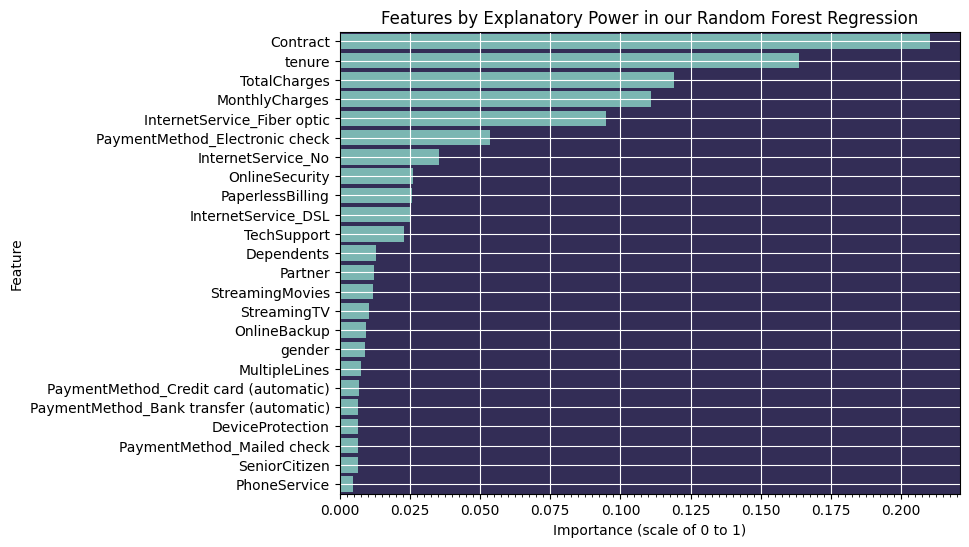

In [ ]:
importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_,
})
importances = importances.sort_values("Importance", ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importances,
    x="Importance",
    y="Feature",
    color=palette["teal"]
)
plt.title("Features by Explanatory Power in our Random Forest Regression")
plt.grid(color="white")
plt.xlabel("Importance (scale of 0 to 1)")
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
ax.set_facecolor(palette["navy"])
plt.show()

## Feature importance (SHAP)

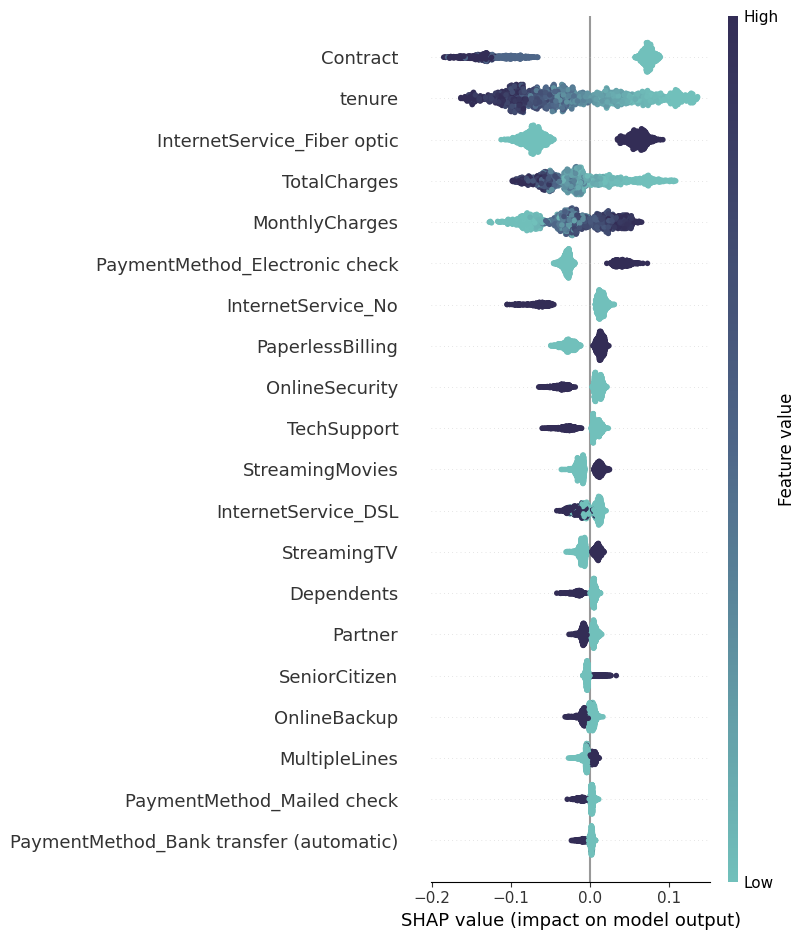

In [65]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
custom_cmap = LinearSegmentedColormap.from_list("custom", [palette["teal"], palette["blue"], palette["navy"]])
shap.summary_plot(shap_values[:,:,1], X_test, feature_names=X.columns, cmap=custom_cmap, title="Feature Important (0 to 1)")

###Insights

1. **Contract length and tenure** are the two most important features and both decrease churn.  
   - **Implication:** Incentivising long-term contracts and offering bonuses or small discounts for contract renewals could help retain customers.  

2. **Charges have nuanced effects:**  
   - **TotalCharges** appears to decrease churn because it is strongly correlated with tenure — longer-tenured customers have higher totals and are less likely to leave.  
   - **MonthlyCharges** shows an ambiguous effect: higher monthly charges can increase churn for customers who feel overpriced, but may also be associated with customers less sensitive to switching.  
   - **Implication:** Both features are important, but further investigation is recommended to design pricing strategies or promotions effectively.  

3. **Technology access:** Customers with higher technology usage (e.g., fibre optic internet, electronic payments) are slightly more likely to churn.  
   - **Reasoning:** Greater technological access may reduce the friction to switch providers.  
   - **Implication:** Consider offering optional paper billing or “cooling-off” periods for online account changes to reduce unintentional churn.  

4. **Service quality:** Strong online security and technical support reduce churn.  
   - **Implication:** Investments in these programs are justified and should be weighed in cost/benefit analyses.  

5. **Demographics:**  
   - Senior citizens are more likely to churn.  
   - Customers with partners and children are less likely to churn.  
   - **Implication:** Household composition and available free time appear to influence churn behaviour, which could inform targeted retention campaigns.

## ROC Curve

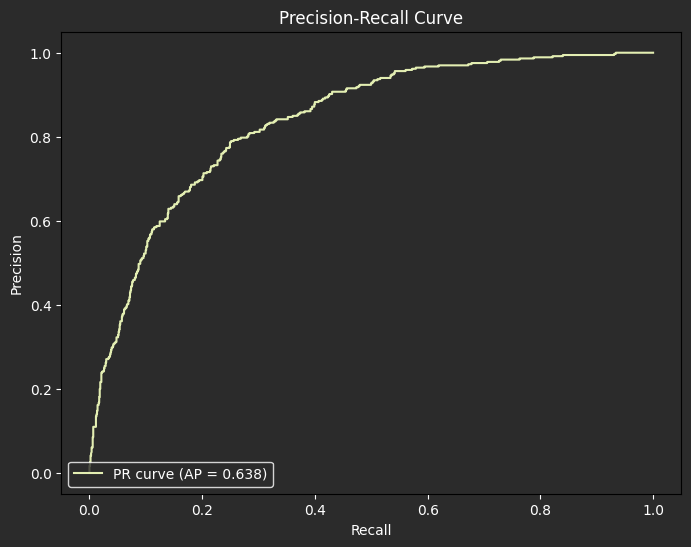

In [70]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor(palette["grey"])
ax.set_facecolor(palette["grey"])
ax.plot(fpr, tpr, color=palette["sage"], label=f'PR curve (AP = {avg_precision:.3f})')

ax.set_xlabel('Recall', color='white')
ax.set_ylabel('Precision', color='white')
ax.set_title('Precision-Recall Curve', color='white')
ax.legend(loc='lower left', facecolor=palette["grey"], edgecolor='white', labelcolor='white')
ax.tick_params(colors='white')
plt.show()

## Precision-Recall Curve

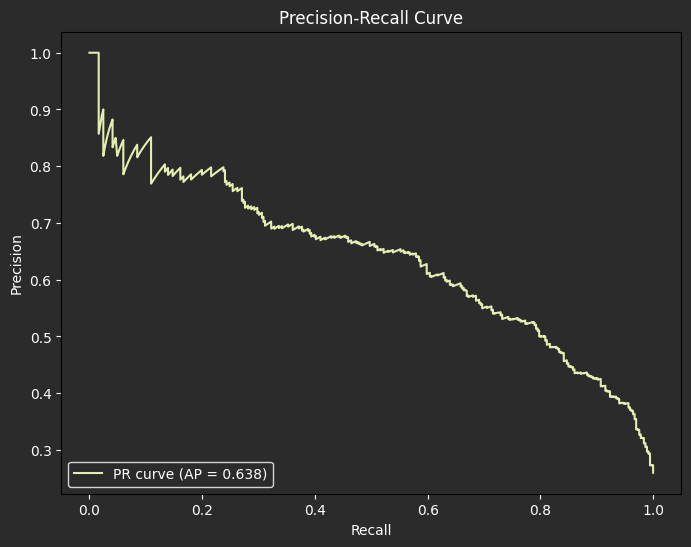

In [69]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor(palette["grey"])
ax.set_facecolor(palette["grey"])
ax.plot(recall, precision, color=palette["sage"], label=f'PR curve (AP = {avg_precision:.3f})')

ax.set_xlabel('Recall', color='white')
ax.set_ylabel('Precision', color='white')
ax.set_title('Precision-Recall Curve', color='white')
ax.legend(loc='lower left', facecolor=palette["grey"], edgecolor='white', labelcolor='white')
ax.tick_params(colors='white')
plt.show()

## Confusion Matrix Heatmap


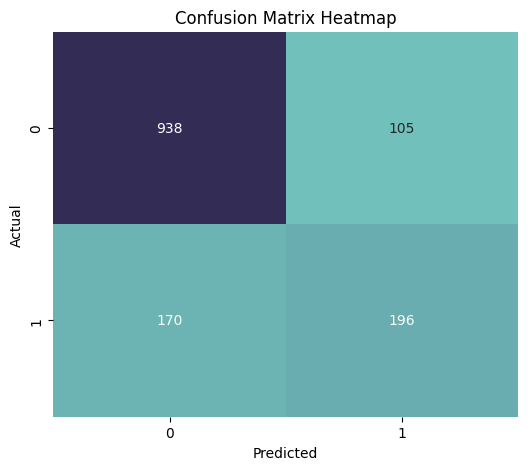

In [66]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## 5-Conclusion

This project set out to build a machine learning model to predict customer churn using the Telco Kaggle dataset. We developed a random classifer that achieved strong performance, with an ROC-AUC of ~0.84, whilst weighting the model toward reducing false negatives.

Key findings include:
* We now have a **predictive model** that can identify at-risk customers and target retention campaigns with a high degree of accuracy.
* **Contract length and tenure** are the strongest predictors of churn.
* **Service quality** features (online security, technical support) significantly reduce churn.
* Churn is more common among more **digitally connected** customers, who can easily switch providers.
* **Demographics** matter: older customers are more likely to churn, while those with partners or dependents are less likely — suggesting free time plays a role in churn behaviour.

From a business perspective, this suggests that companies should:
* Incentivise longer-term contracts through renewals and bonuses.  
* Invest in technical support and online security as retention tools.  
* Tailor promotion campaigns to specific customer segments (e.g., short-tenure, older, or more technologically connected customers).
* Tailor ad campaigns based on the decisions of the Random Forest Classifier

**Limitations:** The class weighting in the model is simulated and does not reflect real company costs. In practice, thresholds and class weighting should be tuned against a cost function that balances the cost of retention campaigns against the loss from customer churn.

**Next steps:** Extend the model to panel data to capture changing marketplace trends and explore how feature importance evolves over time.